<a id='top-page'></a>

# Visualizing the results of running the [`PC-transport.py`](../code/PC-transport.py) script

- [Upload the results](#load-results)
- [Load the training data](#load-data)
- [Compute the low-dimensional manifold parameters](#PCA)
- [Compute the *a priori* closure model assessments](#closure-model-assessment)
- [Visualize the numerical solution](#visualize-numerical-solution)
- [Visualize the transported trajectories](#visualize-trajectories)
- [Visualize the *a posteriori* predictions of the projected source terms](#visualize-source-terms)
- [Visualize the predicted thermo-chemical state variables](#visualize-thermo-chemistry)
- [Assess the thermo-chemistry prediction](#assess-thermo-chemistry-prediction)

***

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from PCAfold import preprocess
from PCAfold import reduction
from PCAfold import analysis
from PCAfold.styles import *

%matplotlib inline

In [2]:
color_rbf = '#f09863'
color_gpr = '#ff5555'
color_ann = '#1c8aa9'
color_kreg = '#0e3a61'

data_tag = 'CO-H2-10-1-isobaric-adiabatic-closed-HR'
data_path = '../data/'
results_path = '../results/'
species_to_remove_list = ['N2', 'AR', 'HE']
sample_percentage = 100
random_seed = 100
n_components = 2
scaling = 'pareto'
run_RBF = True
run_GPR = False
run_ANN = True
run_KReg = True
reconstruct_thermochemistry = True
start_simulation = 120
n_points = 2000
max_simulation_time = 0.005

<a id='load-results'></a>
***

## Upload the results

[Go to the top ↑](#top-page)

In [3]:
if run_RBF:
    PCA_source_terms_predicted_rbf = pd.read_csv(results_path + 'PCA-' + scaling + '-RBF-predicted-source-terms.csv', sep = ',', header=None).to_numpy()
    numerical_solution_rbf_model = pd.read_csv(results_path + 'PCA-' + scaling + '-RBF-numerical-solution.csv', sep = ',', header=None).to_numpy()
    PC_source_terms_from_numerical_solution_rbf = pd.read_csv(results_path + 'PCA-' + scaling + '-RBF-PCA-source-terms-from-numerical-solution.csv', sep = ',', header=None).to_numpy()

if run_GPR:
    PCA_source_terms_predicted_gpr = pd.read_csv(results_path + 'PCA-' + scaling + '-GPR-predicted-source-terms.csv', sep = ',', header=None).to_numpy()
    numerical_solution_gpr_model = pd.read_csv(results_path + 'PCA-' + scaling + '-GPR-numerical-solution.csv', sep = ',', header=None).to_numpy()
    PC_source_terms_from_numerical_solution_gpr = pd.read_csv(results_path + 'PCA-' + scaling + '-GPR-PCA-source-terms-from-numerical-solution.csv', sep = ',', header=None).to_numpy()

if run_ANN:
    PCA_source_terms_predicted_ann = pd.read_csv(results_path + 'PCA-' + scaling + '-ANN-predicted-source-terms.csv', sep = ',', header=None).to_numpy()
    numerical_solution_ann_model = pd.read_csv(results_path + 'PCA-' + scaling + '-ANN-numerical-solution.csv', sep = ',', header=None).to_numpy()
    PC_source_terms_from_numerical_solution_ann = pd.read_csv(results_path + 'PCA-' + scaling + '-ANN-PCA-source-terms-from-numerical-solution.csv', sep = ',', header=None).to_numpy()

if run_KReg:
    PCA_source_terms_predicted_kreg = pd.read_csv(results_path + 'PCA-' + scaling + '-KReg-predicted-source-terms.csv', sep = ',', header=None).to_numpy()
    numerical_solution_kreg_model = pd.read_csv(results_path + 'PCA-' + scaling + '-KReg-numerical-solution.csv', sep = ',', header=None).to_numpy()
    PC_source_terms_from_numerical_solution_kreg = pd.read_csv(results_path + 'PCA-' + scaling + '-KReg-PCA-source-terms-from-numerical-solution.csv', sep = ',', header=None).to_numpy()

if reconstruct_thermochemistry:
    
    if run_RBF: state_space_ROM_predicted_rbf = pd.read_csv(results_path + 'PCA-' + scaling + '-RBF-predicted-state-space.csv', sep = ',', header=None).to_numpy()
    if run_GPR: state_space_ROM_predicted_gpr = pd.read_csv(results_path + 'PCA-' + scaling + '-GPR-predicted-state-space.csv', sep = ',', header=None).to_numpy()
    if run_ANN: state_space_ROM_predicted_ann = pd.read_csv(results_path + 'PCA-' + scaling + '-ANN-predicted-state-space.csv', sep = ',', header=None).to_numpy()
    if run_KReg: state_space_ROM_predicted_kreg = pd.read_csv(results_path + 'PCA-' + scaling + '-KReg-predicted-state-space.csv', sep = ',', header=None).to_numpy()

<a id='load-data'></a>
***

## Load the training data

[Go to the top ↑](#top-page)

In [4]:
state_space_names = pd.read_csv(data_path + data_tag + '-state-space-names.csv', sep = ',', header=None).to_numpy().ravel()
state_space = pd.read_csv(data_path + data_tag + '-state-space.csv', sep = ',', header=None).to_numpy()
state_space_sources = pd.read_csv(data_path + data_tag + '-state-space-sources.csv', sep = ',', header=None).to_numpy()
mixture_fraction = pd.read_csv(data_path + data_tag + '-mixture-fraction.csv', sep = ',', header=None).to_numpy()
time_grid = pd.read_csv(data_path + data_tag + '-time.csv', sep = ',', header=None).to_numpy().ravel()

state_space_test_trajectory = pd.read_csv(data_path + data_tag + '-state-space-test-trajectory.csv', sep = ',', header=None).to_numpy()
state_space_sources_test_trajectory = pd.read_csv(data_path + data_tag + '-state-space-sources-test-trajectory.csv', sep = ',', header=None).to_numpy()
time_grid_test_trajectory = pd.read_csv(data_path + data_tag + '-time-test-trajectory.csv', sep = ',', header=None).to_numpy().ravel()

state_space_support_trajectories = pd.read_csv(data_path + data_tag + '-state-space-support-trajectories.csv', sep = ',', header=None).to_numpy()
state_space_sources_support_trajectories = pd.read_csv(data_path + data_tag + '-state-space-sources-support-trajectories.csv', sep = ',', header=None).to_numpy()
time_grid_support_trajectories = pd.read_csv(data_path + data_tag + '-time-support-trajectories.csv', sep = ',', header=None).to_numpy().ravel()

for species_to_remove in species_to_remove_list:

    (species_index, ) = np.where(state_space_names==species_to_remove)
    if len(species_index) != 0:
        print('Removing ' + state_space_names[int(species_index)] + '.')
        state_space = np.delete(state_space, np.s_[species_index], axis=1)
        state_space_sources = np.delete(state_space_sources, np.s_[species_index], axis=1)

        state_space_test_trajectory = np.delete(state_space_test_trajectory, np.s_[species_index], axis=1)
        state_space_sources_test_trajectory = np.delete(state_space_sources_test_trajectory, np.s_[species_index], axis=1)

        state_space_support_trajectories = np.delete(state_space_support_trajectories, np.s_[species_index], axis=1)
        state_space_sources_support_trajectories = np.delete(state_space_sources_support_trajectories, np.s_[species_index], axis=1)

        state_space_names = np.delete(state_space_names, np.s_[species_index])
    else:
        print(species_to_remove + ' already removed from the data set.')

(n_observations, n_variables) = np.shape(state_space)

if sample_percentage == 100:
    sample_data = False
else:
    sample_data = True

if sample_data:
    idx = np.zeros((n_observations,)).astype(int)
    sample_random = preprocess.DataSampler(idx, random_seed=random_seed, verbose=False)
    (idx_sample, _) = sample_random.random(sample_percentage)

    state_space = state_space[idx_sample,:]
    state_space_sources = state_space_sources[idx_sample,:]
    mf = mf[idx_sample,:]

    (n_observations, n_variables) = np.shape(state_space)

print('\nThe data set has ' + str(n_observations) + ' observations.')

Removing N2.
AR already removed from the data set.
HE already removed from the data set.

The data set has 68140 observations.


<a id='PCA'></a>
***

## Compute the low-dimensional manifold parameters

[Go to the top ↑](#top-page)

In [5]:
pca = reduction.PCA(state_space, scaling=scaling, n_components=n_components)
PCA_basis = pca.A[:,0:n_components]
centers = pca.X_center
scales = pca.X_scale

X_CS = (state_space - centers) / scales
S_CS = state_space_sources / scales

state_space_test_trajectory_CS = (state_space_test_trajectory - centers)/scales
state_space_sources_test_trajectory_CS = state_space_sources_test_trajectory / scales

state_space_support_trajectories_CS = (state_space_support_trajectories - centers)/scales
state_space_sources_support_trajectories_CS = state_space_sources_support_trajectories / scales

X_PCA = np.dot(X_CS, PCA_basis)
S_PCA = np.dot(S_CS, PCA_basis)

X_PCA_CS, center_PCA, scale_PCA = preprocess.center_scale(X_PCA, scaling='-1to1')

PCA_state_space_test_trajectory = np.dot(state_space_test_trajectory_CS, PCA_basis)
PCA_state_space_test_trajectory_CS = (PCA_state_space_test_trajectory - center_PCA) / scale_PCA
PCA_source_terms_test_trajectory = np.dot(state_space_sources_test_trajectory_CS, PCA_basis)

PCA_state_space_support_trajectories = np.dot(state_space_support_trajectories_CS, PCA_basis)
PCA_state_space_support_trajectories_CS = (PCA_state_space_support_trajectories - center_PCA) / scale_PCA
PCA_source_terms_support_trajectories = np.dot(state_space_sources_support_trajectories_CS, PCA_basis)

PCA_source_terms_support_trajectories_CS, centers_PCA_source_terms, scales_PCA_source_terms = preprocess.center_scale(PCA_source_terms_support_trajectories, scaling='-1to1')

(n_observations, _) = PCA_state_space_support_trajectories.shape

In [6]:
PCA_initial_condition = PCA_state_space_test_trajectory[start_simulation,:]
t_coordinates = np.linspace(time_grid_test_trajectory[start_simulation],max_simulation_time,n_points)

<a id='closure-model-assessment'></a>
***

## Compute the *a priori* closure model assessments

[Go to the top ↑](#top-page)

In [7]:
if run_RBF:
    RBF_metrics = analysis.RegressionAssessment(PCA_source_terms_test_trajectory, PCA_source_terms_predicted_rbf, variable_names=['$S_{\eta, 1}$', '$S_{\eta, 2}$'])
    RBF_metrics.print_metrics(table_format=['pandas'], float_format='.8f', metrics=['R2', 'MSLE', 'NRMSE', 'GDE'])

,R2,MSLE,NRMSE,GDE
"$S_{\eta, 1}$",0.99999999,0.55478600,0.00010164,93.50427350
"$S_{\eta, 2}$",0.99999996,0.01013815,0.00020000,93.50427350


In [8]:
if run_GPR:
    GPR_metrics = analysis.RegressionAssessment(PCA_source_terms_test_trajectory, PCA_source_terms_predicted_gpr, variable_names=['$S_{\eta, 1}$', '$S_{\eta, 2}$'])
    GPR_metrics.print_metrics(table_format=['pandas'], float_format='.8f', metrics=['R2', 'MSLE', 'NRMSE', 'GDE'])

,R2,MSLE,NRMSE,GDE
"$S_{\eta, 1}$",0.99999997,0.82167110,0.00017085,93.21937322
"$S_{\eta, 2}$",1.00000000,0.00017805,0.00005867,93.21937322


In [9]:
if run_ANN:
    ANN_metrics = analysis.RegressionAssessment(PCA_source_terms_test_trajectory, PCA_source_terms_predicted_ann, variable_names=['$S_{\eta, 1}$', '$S_{\eta, 2}$'])
    ANN_metrics.print_metrics(table_format=['pandas'], float_format='.8f', metrics=['R2', 'MSLE', 'NRMSE', 'GDE'])

,R2,MSLE,NRMSE,GDE
"$S_{\eta, 1}$",0.99989815,4.84859203,0.01009201,99.88603989
"$S_{\eta, 2}$",0.99979260,0.32573070,0.01440144,99.88603989


In [10]:
if run_KReg:
    KReg_metrics = analysis.RegressionAssessment(PCA_source_terms_test_trajectory, PCA_source_terms_predicted_kreg, variable_names=['$S_{\eta, 1}$', '$S_{\eta, 2}$'])
    KReg_metrics.print_metrics(table_format=['pandas'], float_format='.8f', metrics=['R2', 'MSLE', 'NRMSE', 'GDE'])

,R2,MSLE,NRMSE,GDE
"$S_{\eta, 1}$",0.99999641,2.52766996,0.00189512,99.88603989
"$S_{\eta, 2}$",0.99999361,0.13571720,0.00252774,99.88603989


<a id='visualize-numerical-solution'></a>
***

## Visualize the numerical solution

[Go to the top ↑](#top-page)

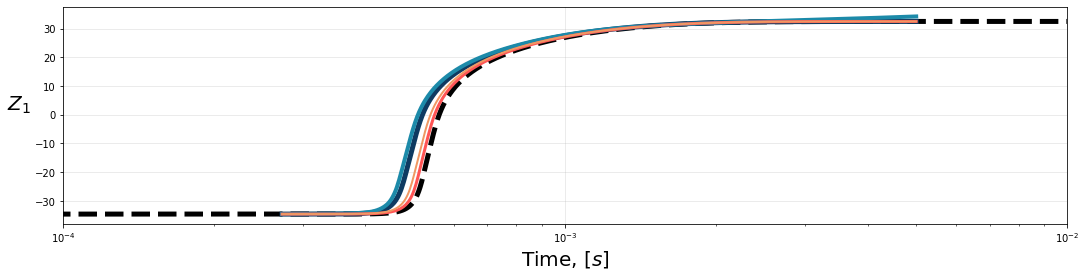

In [11]:
plt.figure(figsize=(18,4))

plt.semilogx(time_grid_test_trajectory, PCA_state_space_test_trajectory[:,0], 'k--', lw=5, zorder=5)
plt.xlim([10**-4,10**-2])

if run_RBF: plt.semilogx(t_coordinates, numerical_solution_rbf_model[:,0], '-', lw=2, color=color_rbf, zorder=40)
if run_GPR: plt.semilogx(t_coordinates, numerical_solution_gpr_model[:,0], '-', lw=3, color=color_gpr, zorder=30)
if run_ANN: plt.semilogx(t_coordinates, numerical_solution_ann_model[:,0], '-', lw=4, color=color_ann, zorder=20)
if run_KReg: plt.semilogx(t_coordinates, numerical_solution_kreg_model[:,0], '-', lw=5, color=color_kreg, zorder=10)

plt.xlabel('Time, [$s$]', fontsize=20)
plt.ylabel('$Z_{1}$', fontsize=20, rotation=0, horizontalalignment='right')
plt.grid(alpha=0.3, zorder=1);
plt.savefig(results_path + 'PCA-' + scaling + '-a-posteriori-Z1-path.png', dpi=300, bbox_inches='tight')

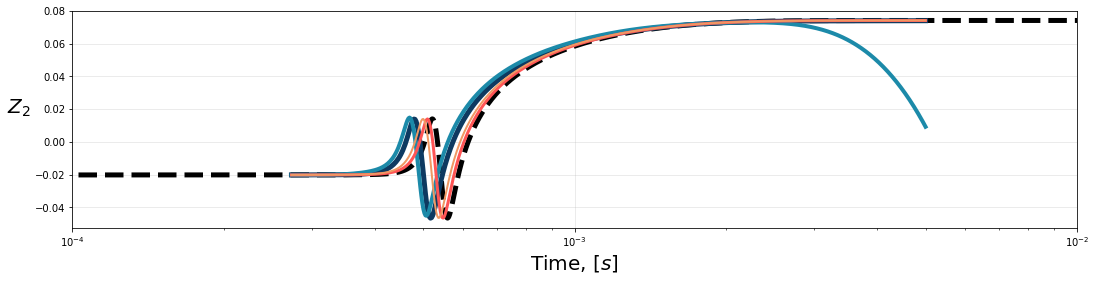

In [12]:
plt.figure(figsize=(18,4))

plt.semilogx(time_grid_test_trajectory, PCA_state_space_test_trajectory[:,1], 'k--', lw=5, zorder=5)
plt.xlim([10**-4,10**-2])

if run_RBF: plt.semilogx(t_coordinates, numerical_solution_rbf_model[:,1], '-', lw=2, color=color_rbf, zorder=40)
if run_GPR: plt.semilogx(t_coordinates, numerical_solution_gpr_model[:,1], '-', lw=3, color=color_gpr, zorder=30)
if run_ANN: plt.semilogx(t_coordinates, numerical_solution_ann_model[:,1], '-', lw=4, color=color_ann, zorder=20)
if run_KReg: plt.semilogx(t_coordinates, numerical_solution_kreg_model[:,1], '-', lw=5, color=color_kreg, zorder=10)

plt.xlabel('Time, [$s$]', fontsize=20)
plt.ylabel('$Z_{2}$', fontsize=20, rotation=0, horizontalalignment='right')
plt.grid(alpha=0.3, zorder=1)
plt.savefig(results_path + 'PCA-' + scaling + '-a-posteriori-Z2-path.png', dpi=300, bbox_inches='tight')

<a id='visualize-trajectories'></a>
***

## Visualize the transported trajectories

[Go to the top ↑](#top-page)

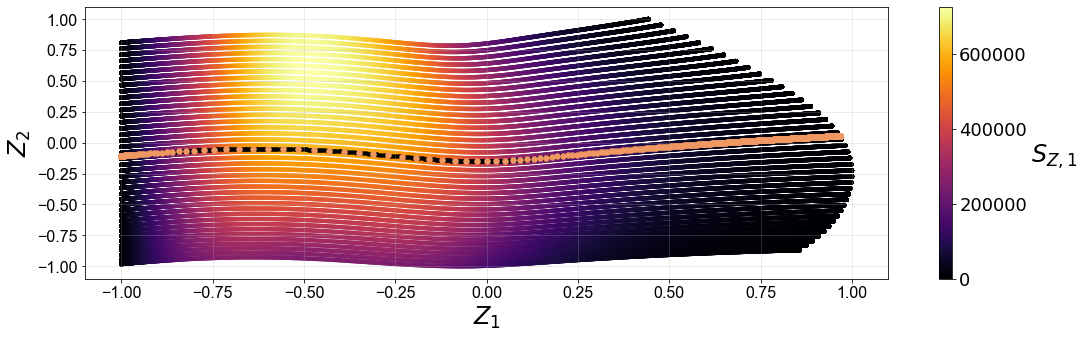

In [13]:
if run_RBF:

    numerical_solution_rbf_model_CS = (numerical_solution_rbf_model - center_PCA) / scale_PCA

    plt = reduction.plot_2d_manifold(X_PCA_CS[:,0],
                                     X_PCA_CS[:,1],
                                     s=20,
                                     color=S_PCA[:,0],
                                     color_map='inferno',
                                     x_label='$Z_1$',
                                     y_label='$Z_2$',
                                     colorbar_label='$S_{Z, 1}$',
                                     figure_size=(18,5));

    plt.scatter(numerical_solution_rbf_model_CS[:,0], numerical_solution_rbf_model_CS[:,1], c=color_rbf, s=30, zorder=100)
    plt.scatter(PCA_state_space_test_trajectory_CS[:,0], PCA_state_space_test_trajectory_CS[:,1], c='k', s=10, zorder=1);
    plt.savefig(results_path + 'PCA-' + scaling + '-RBF-transported-trajectory.png', dpi=300, bbox_inches='tight')

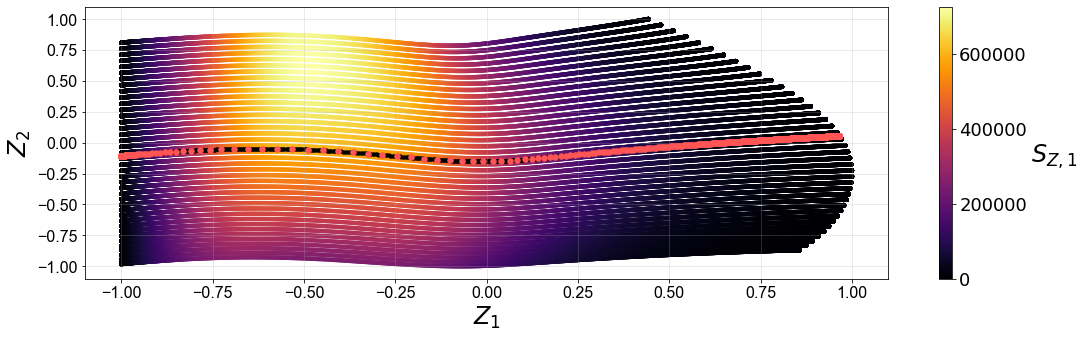

In [14]:
if run_GPR:

    numerical_solution_gpr_model_CS = (numerical_solution_gpr_model - center_PCA) / scale_PCA

    plt = reduction.plot_2d_manifold(X_PCA_CS[:,0],
                                     X_PCA_CS[:,1],
                                     s=20,
                                     color=S_PCA[:,0],
                                     color_map='inferno',
                                     x_label='$Z_1$',
                                     y_label='$Z_2$',
                                     colorbar_label='$S_{Z, 1}$',
                                     figure_size=(18,5));

    plt.scatter(numerical_solution_gpr_model_CS[:,0], numerical_solution_gpr_model_CS[:,1], c=color_gpr, s=30, zorder=100)
    plt.scatter(PCA_state_space_test_trajectory_CS[:,0], PCA_state_space_test_trajectory_CS[:,1], c='k', s=10, zorder=1);
    plt.savefig(results_path + 'PCA-' + scaling + '-GPR-transported-trajectory.png', dpi=300, bbox_inches='tight')

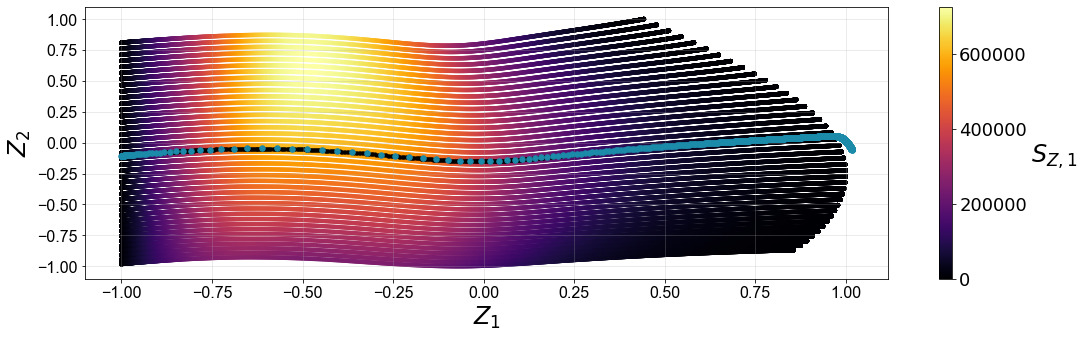

In [15]:
if run_ANN:
    
    numerical_solution_ann_model_CS = (numerical_solution_ann_model - center_PCA) / scale_PCA

    plt = reduction.plot_2d_manifold(X_PCA_CS[:,0],
                                     X_PCA_CS[:,1],
                                     s=20,
                                     color=S_PCA[:,0],
                                     color_map='inferno',
                                     x_label='$Z_1$',
                                     y_label='$Z_2$',
                                     colorbar_label='$S_{Z, 1}$',
                                     figure_size=(18,5));

    plt.scatter(numerical_solution_ann_model_CS[:,0], numerical_solution_ann_model_CS[:,1], c=color_ann, s=30, zorder=100)
    plt.scatter(PCA_state_space_test_trajectory_CS[:,0], PCA_state_space_test_trajectory_CS[:,1], c='k', s=10, zorder=1);
    plt.savefig(results_path + 'PCA-' + scaling + '-ANN-transported-trajectory.png', dpi=300, bbox_inches='tight')

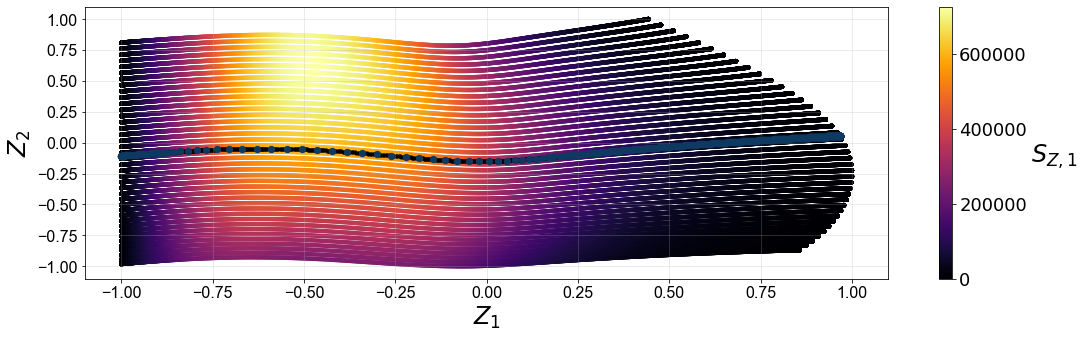

In [16]:
if run_KReg:
    
    numerical_solution_kreg_model_CS = (numerical_solution_kreg_model - center_PCA) / scale_PCA

    plt = reduction.plot_2d_manifold(X_PCA_CS[:,0],
                                     X_PCA_CS[:,1],
                                     s=20,
                                     color=S_PCA[:,0],
                                     color_map='inferno',
                                     x_label='$Z_1$',
                                     y_label='$Z_2$',
                                     colorbar_label='$S_{Z, 1}$',
                                     figure_size=(18,5));

    plt.scatter(numerical_solution_kreg_model_CS[:,0], numerical_solution_kreg_model_CS[:,1], c=color_kreg, s=40, zorder=100)
    plt.scatter(PCA_state_space_test_trajectory_CS[:,0], PCA_state_space_test_trajectory_CS[:,1], c='k', s=10, zorder=1);
    plt.savefig(results_path + 'PCA-' + scaling + '-KReg-transported-trajectory.png', dpi=300, bbox_inches='tight')

<a id='visualize-source-terms'></a>

***

## Visualize the *a posteriori* predictions of the projected source terms

[Go to the top ↑](#top-page)

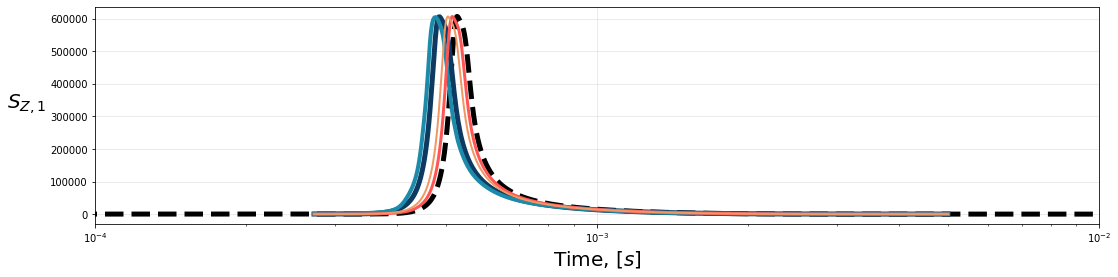

In [17]:
plt.figure(figsize=(18,4))

plt.semilogx(time_grid_test_trajectory, PCA_source_terms_test_trajectory[:,0], 'k--', lw=5, zorder=5)
plt.xlim([10**-4,10**-2])

if run_RBF: plt.semilogx(t_coordinates, PC_source_terms_from_numerical_solution_rbf[:,0], '-', lw=2, color=color_rbf, zorder=40)
if run_GPR: plt.semilogx(t_coordinates, PC_source_terms_from_numerical_solution_gpr[:,0], '-', lw=3, color=color_gpr, zorder=30)
if run_ANN: plt.semilogx(t_coordinates, PC_source_terms_from_numerical_solution_ann[:,0], '-', lw=4, color=color_ann, zorder=20)
if run_KReg: plt.semilogx(t_coordinates, PC_source_terms_from_numerical_solution_kreg[:,0], '-', lw=5, color=color_kreg, zorder=10)

plt.xlabel('Time, [$s$]', fontsize=20)
plt.ylabel('$S_{Z, 1}$', fontsize=20, rotation=0, horizontalalignment='right')
plt.grid(alpha=0.3, zorder=1)
plt.savefig(results_path + 'PCA-' + scaling + '-a-posteriori-SZ1-prediction.png', dpi=300, bbox_inches='tight');

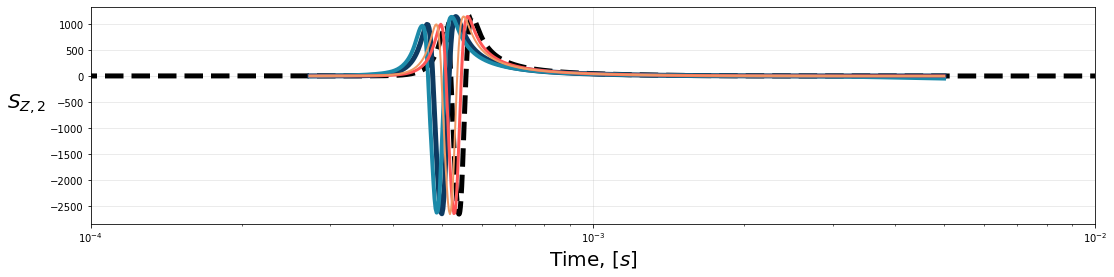

In [18]:
plt.figure(figsize=(18,4))

plt.semilogx(time_grid_test_trajectory, PCA_source_terms_test_trajectory[:,1], 'k--', lw=5, zorder=5)
plt.xlim([10**-4,10**-2])

if run_RBF: plt.semilogx(t_coordinates, PC_source_terms_from_numerical_solution_rbf[:,1], '-', lw=2, color=color_rbf, zorder=40)
if run_GPR: plt.semilogx(t_coordinates, PC_source_terms_from_numerical_solution_gpr[:,1], '-', lw=3, color=color_gpr, zorder=30)
if run_ANN: plt.semilogx(t_coordinates, PC_source_terms_from_numerical_solution_ann[:,1], '-', lw=4, color=color_ann, zorder=20)
if run_KReg: plt.semilogx(t_coordinates, PC_source_terms_from_numerical_solution_kreg[:,1], '-', lw=5, color=color_kreg, zorder=10)

plt.xlabel('Time, [$s$]', fontsize=20)
plt.ylabel('$S_{Z, 2}$', fontsize=20, rotation=0, horizontalalignment='right')
plt.grid(alpha=0.3, zorder=1)
plt.savefig(results_path + 'PCA-' + scaling + '-a-posteriori-SZ2-prediction.png', dpi=300, bbox_inches='tight');

<a id='visualize-thermo-chemistry'></a>

***

## Visualize the predicted thermo-chemical state variables

[Go to the top ↑](#top-page)

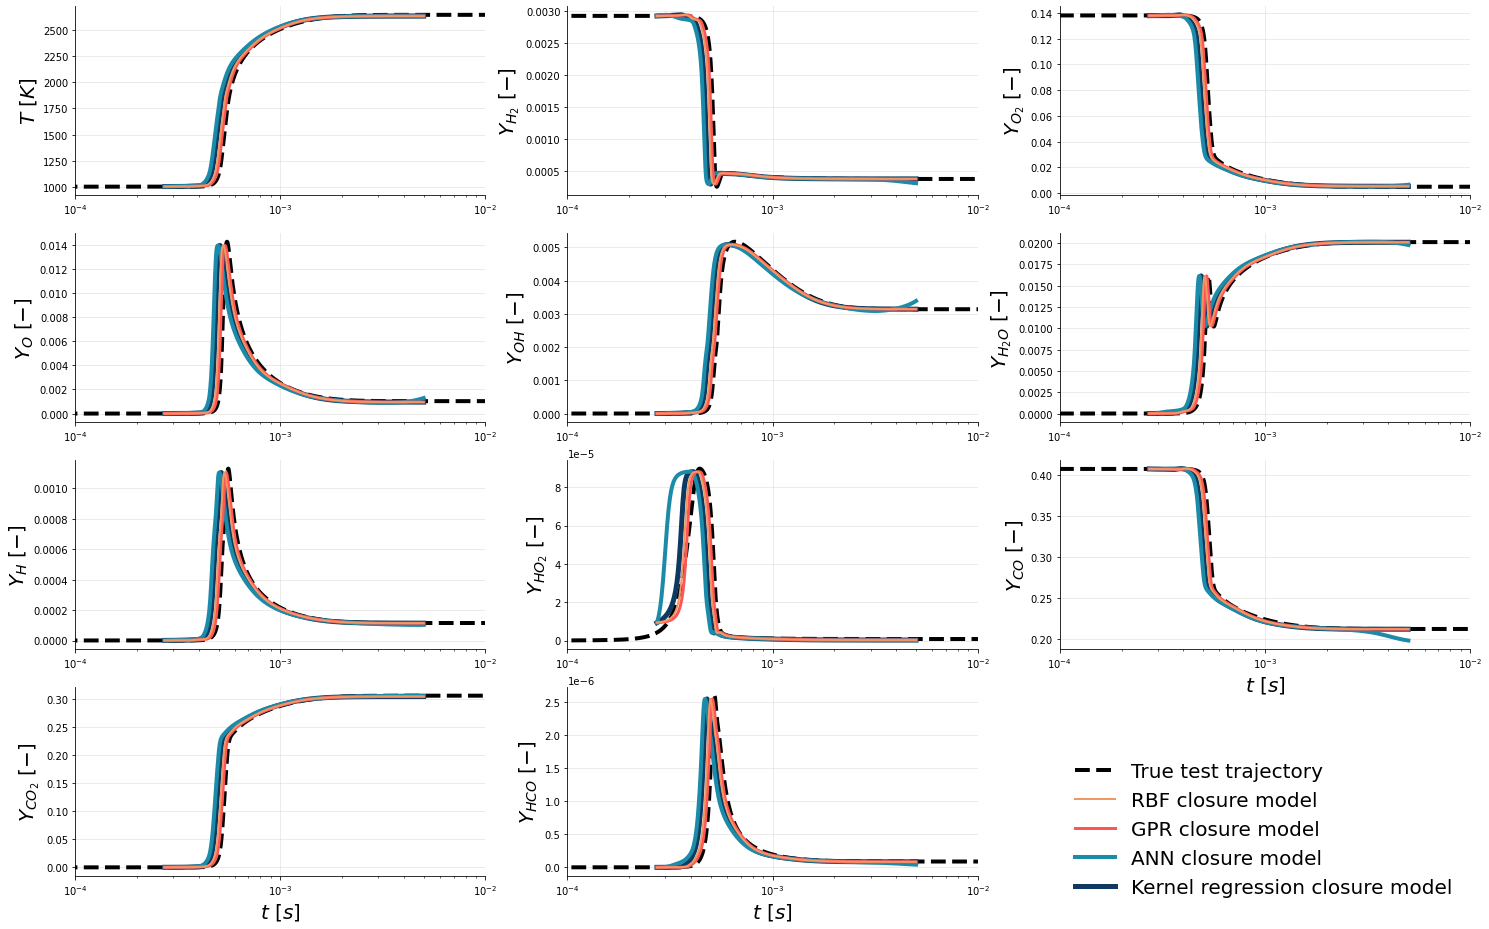

In [19]:
if reconstruct_thermochemistry:
    
    selected_state_variables = [0,1,2,3,4,5,6,7,8,9,10]
    state_space_names_neat = ['$T$ [$K$]', '$Y_{H_2}$ [$-$]', '$Y_{O_2}$ [$-$]', '$Y_{O}$ [$-$]', '$Y_{OH}$ [$-$]', '$Y_{H_2O}$ [$-$]', '$Y_{H}$ [$-$]', '$Y_{HO_2}$ [$-$]', '$Y_{CO}$ [$-$]', '$Y_{CO_2}$ [$-$]', '$Y_{HCO}$ [$-$]']

    figure = plt.figure(figsize=(25, 16))
    spec = figure.add_gridspec(ncols=3, nrows=int(np.ceil(n_variables/3)), width_ratios=[1,1,1], height_ratios=[1 for i in range(0,int(np.ceil(n_variables/3)))])
    for i in range(0,len(selected_state_variables)):
        figure_a = figure.add_subplot(spec[int(np.floor(i/3)),i%3])
        plt.semilogx(time_grid_test_trajectory, state_space_test_trajectory[:,selected_state_variables[i]], 'k--', lw=4, alpha=1, zorder=5, label='True test trajectory')

        if run_RBF: plt.semilogx(t_coordinates, state_space_ROM_predicted_rbf[:,i], c=color_rbf, lw=2, zorder=40, label='RBF closure model')
        if run_GPR: plt.semilogx(t_coordinates, state_space_ROM_predicted_gpr[:,i], c=color_gpr, lw=3, zorder=30, label='GPR closure model')
        if run_ANN: plt.semilogx(t_coordinates, state_space_ROM_predicted_ann[:,i], c=color_ann, lw=4, zorder=20, label='ANN closure model')
        if run_KReg: plt.semilogx(t_coordinates, state_space_ROM_predicted_kreg[:,i], c=color_kreg, lw=5, zorder=10, label='Kernel regression closure model')
        plt.xlim([10**-4,10**-2])
        plt.grid(alpha=0.3, zorder=1);
        plt.ylabel(state_space_names_neat[selected_state_variables[i]], fontsize=20, rotation=90)
        if i==len(selected_state_variables)-3: plt.xlabel('$t$ [$s$]', fontsize=20)
        if i==len(selected_state_variables)-2: plt.xlabel('$t$ [$s$]', fontsize=20)
        if i==len(selected_state_variables)-1: plt.xlabel('$t$ [$s$]', fontsize=20)
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)

        if i==len(selected_state_variables)-1: plt.legend(frameon=False, bbox_to_anchor=(2.2, 0.7), fontsize=20, ncol=1)

    plt.savefig(results_path + 'PCA-' + scaling + '-predicted-thermo-chemistry.png', dpi=300, bbox_inches='tight')

<a id='assess-thermo-chemistry-prediction'></a>

***

## Assess the thermo-chemistry prediction

#### The cells below will only work if the `t_coordinates` vector used in the PC-transport simulation is the same as the `time_grid` vector for that dataset.

[Go to the top ↑](#top-page)

In [ ]:
state_rbf_metrics = analysis.RegressionAssessment(state_space_test_trajectory[start_simulation::,selected_state_variables], state_space_ROM_predicted_rbf, variable_names=list(state_space_names[selected_state_variables]))
state_rbf_metrics.print_metrics(table_format=['pandas'], float_format='.8f', metrics=['R2', 'MSLE', 'NRMSE'])

In [ ]:
state_ann_metrics = analysis.RegressionAssessment(state_space_test_trajectory[start_simulation::,selected_state_variables], state_space_ROM_predicted_ann, variable_names=list(state_space_names[selected_state_variables]))
state_ann_metrics.print_metrics(table_format=['pandas'], float_format='.8f', metrics=['R2', 'MSLE', 'NRMSE'], comparison=state_rbf_metrics)

In [ ]:
state_kreg_metrics = analysis.RegressionAssessment(state_space_test_trajectory[start_simulation::,selected_state_variables], state_space_ROM_predicted_kreg, variable_names=list(state_space_names[selected_state_variables]))
state_kreg_metrics.print_metrics(table_format=['pandas'], float_format='.8f', metrics=['R2', 'MSLE', 'NRMSE'], comparison=state_rbf_metrics)

In [ ]:
state_gpr_metrics = analysis.RegressionAssessment(state_space_test_trajectory[start_simulation::,selected_state_variables], state_space_ROM_predicted_gpr, variable_names=list(state_space_names[selected_state_variables]))
state_gpr_metrics.print_metrics(table_format=['pandas'], float_format='.8f', metrics=['R2', 'MSLE', 'NRMSE'], comparison=state_rbf_metrics)

***